# Cleaning zomatoData csv  and some Analysis

In [1827]:
import pandas as pd
import numpy as np
import ast
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [1828]:
df = pd.read_csv("zomato_extracted_data_csv/zomato_extracted_data.csv",encoding = "ISO-8859-1",na_values=["NA",'-'])

In [1829]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6147 entries, 0 to 6146
Data columns (total 23 columns):
restaurant_link           6147 non-null object
restaurant_ID             6147 non-null int64
restaurant_name           6147 non-null object
locality                  6147 non-null object
restaurant_category       6142 non-null object
zomato_gold               347 non-null object
discounts                 738 non-null object
photos_taken              6147 non-null int64
rating                    5328 non-null float64
votes                     5310 non-null float64
cuisines                  6147 non-null object
approx_cost_for_2         6147 non-null int64
opening_timings           6143 non-null object
address                   6041 non-null object
latitude                  5682 non-null float64
longitude                 5682 non-null float64
more_info                 6147 non-null object
featured_in               761 non-null object
known_for                 290 non-null object
mos

In [1830]:
df.head(3)

,restaurant_link,restaurant_ID,restaurant_name,locality,restaurant_category,zomato_gold,discounts,photos_taken,rating,votes,...,address,latitude,longitude,more_info,featured_in,known_for,most_liked_Food,most_liked_Service,most_liked_Look & Feel,reviews
0,https://www.zomato.com/bangalore/abs-absolute-...,56618,AB's - Absolute Barbecues,Marathahalli,Casual Dining,zomato gold,NaN,4665,4.8,14700.0,...,"90/4, 3rd Floor, Outer Ring Road, Munnekollaly...",12.949798,77.699308,"['Wheelchair Accessible', 'Full Bar Available'...","['Great Buffets', ""Bengaluru's Finest""]",serving varieties of meat,"['5/5', 'Fish', 'Paan Ice Cream', 'Sea Food', ...","['4/5', 'Friendly Staff', 'Courteous Staff', '...","['4/5', 'Live Grill', 'Lovely Ambience', 'Decor']","(['2019-12-03 12:40:39', 'positive', 'NA', 'Go..."
1,https://www.zomato.com/bangalore/uru-brewpark-...,19122613,URU Brewpark,JP Nagar,Microbrewery,NaN,NaN,776,4.3,1421.0,...,"Maratt Estate, 4th Phase, Near Maratt Pimento,...",12.905891,77.601274,"['Home Delivery', 'Full Bar Available', 'Night...",['Sneak Peek Bengaluru'],NaN,"['4/5', 'Pizza', 'Nachos', 'Beer', 'Tiramisu',...","['4/5', 'Courteous Staff', 'Friendly Staff', '...","['4/5', 'Decor']","(['2020-01-08 18:17:08', 'positive', 'NA', 'Th..."
2,https://www.zomato.com/bangalore/the-big-barbe...,19203051,The Big Barbeque,Marathahalli,Casual Dining,NaN,NaN,609,4.7,1744.0,...,"88, 2nd Floor, Outer Ring Road, Near More Supe...",12.948399,77.698877,"['Full Bar Available', 'Free Parking', 'Live M...","['Sneak Peek Bengaluru', 'Corporate Favorites'...",NaN,NaN,NaN,NaN,"(['2020-01-17 08:23:30', 'NA', 'NA', ""Food : 5..."


In [1831]:
df.shape

(6147, 23)

In [1832]:
df = df.drop_duplicates("restaurant_ID",keep='first')

In [1833]:
df.shape

(5637, 23)

In [1834]:
def listToTuple(reviews):
    if isinstance(reviews,str):
        reviewList = ast.literal_eval(reviews)
        if len(reviewList)>0 and isinstance(reviewList,list):
            tup = (reviewList[0],reviewList[1:])
            return tuple(tup)

In [1835]:
df["most_liked_Food"] = df["most_liked_Food"].apply(listToTuple)    
df["most_liked_Service"] = df["most_liked_Service"].apply(listToTuple)
df["most_liked_Look & Feel"] = df["most_liked_Look & Feel"].apply(listToTuple)

In [1836]:
def formatTime(timing):
    if isinstance(timing,str):
        if timing is np.nan or timing == "[]":
            return "NA"
        timings = ast.literal_eval(timing)
        newtime = ['12:00' if timed == '12noon' else '00:00' if timed == "12midnight" else timed if ("24" in timed) else datetime.strptime(timed,'%I%p').strftime('%H:%M') if len(timed)<5 else datetime.strptime(timed,'%I:%M%p').strftime('%H:%M') for timed in timings]
        return newtime

In [1837]:
df["opening_timings"] = df["opening_timings"].apply(formatTime)

In [1838]:
df['cuisines'] = [x.split(",") if isinstance(x,str) else x for x in df["cuisines"]]

In [1839]:
df.to_csv("zomato_clean_data_csv/zomato_clean_data"+".csv",index=False)

In [1840]:
#reading the new clean data
df = pd.read_csv("zomato_clean_data_csv/zomato_clean_data.csv")

In [1841]:
#shuffling df

from sklearn.utils import shuffle
df = shuffle(df)

In [1842]:
df.index = df["restaurant_ID"]
df.drop(["restaurant_ID"],axis=1,inplace=True)

In [1843]:
df.shape

(5637, 22)

# Some Interesting Insights#

# 1.Different Restaurant categories and their counts

In [1844]:
plt.style.use('ggplot')

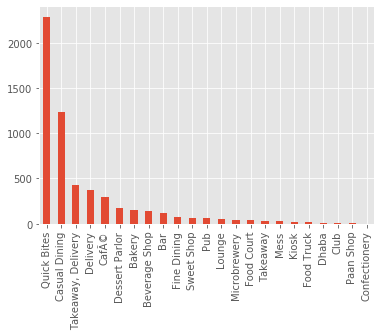

In [1845]:
df["restaurant_category"].value_counts().plot.bar()

Quick bites and Casual dining are the most common of all restaurant categories

# 2. Most Unique cuisines

In [1846]:
df['cuisines'] = df['cuisines'].apply(ast.literal_eval)

In [1847]:
cuisines_series = df['cuisines'].apply(pd.Series).stack().reset_index(drop=True)

In [1848]:
cuisines_series.value_counts(ascending = True)

Parsi               1
 Iranian            1
Gujarati            1
Nepalese            1
Malaysian           1
                 ... 
 Fast Food        616
South Indian      730
 North Indian    1098
North Indian     1537
 Chinese         1694
Length: 175, dtype: int64

Parsi,Iranian are some of rare cuisines

# 3.Which locality has maximum restaurants which are in featured in 'newly opened'?

In [1849]:
dffeatured = df.dropna(subset=['featured_in'])

In [1850]:
dffeatured['featured_in'].apply(ast.literal_eval)

restaurant_ID
50915                                              [Darshini]
18644898                                         [Boozy Bars]
60375                                           [Sweet Tooth]
18339884                                         [Boozy Bars]
58847                                       [Kickass Burgers]
                                  ...                        
18716310    [Corporate Favorites, Best Bars and Pubs, Happ...
52093                                    [Bengaluru's Finest]
18323126                                        [Sweet Tooth]
50499                         [Pizza Time!, Great Breakfasts]
59638                       [Microbreweries, Sunday Brunches]
Name: featured_in, Length: 739, dtype: object

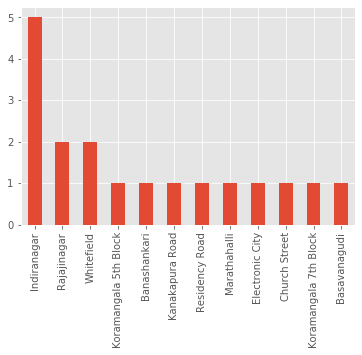

In [1851]:
dffeatured["locality"][dffeatured['featured_in'].apply(lambda x: 'Newly Opened' in x)].value_counts().plot.bar()

Indiranagar has the most restaurants featured under 'newly opened'.  

# 4.Average cost of 2 for a restaurant category 

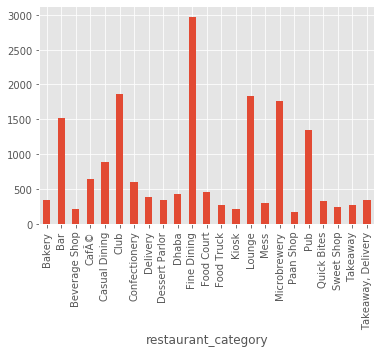

In [1852]:
df.groupby("restaurant_category")['approx_cost_for_2'].mean().plot.bar()

Fine dining category has the highest cost for 2 people.

# 5.Average restaurant rating in locality

In [1853]:
df['rating'] = df['rating'].astype(float)

In [1854]:
dfmeanratings = df.groupby("locality")['rating'].mean()
dfmeanratings.sort_values(ascending=False)

locality
Sankey Road              4.225000
Lavelle Road             4.143333
Church Street            4.095833
Race Course Road         4.084211
Koramangala 5th Block    4.061290
                           ...   
CV Raman Nagar           3.526087
Ejipura                  3.520000
Uttarahalli              3.515385
Bommanahalli             3.500000
City Market              3.476923
Name: rating, Length: 96, dtype: float64

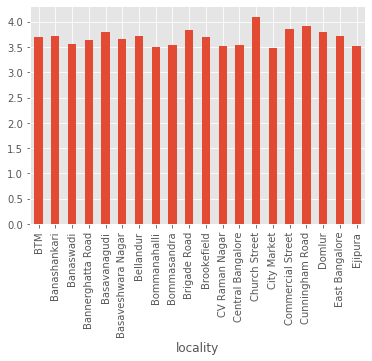

In [1855]:
#Plotting avg rating of first 20 localities
dfmeanratingsTop20 = dfmeanratings[0:20]
dfmeanratingsTop20.plot.bar()

Looking at the plot we can say the average ratings of the restaurants vary based on the locality they are in, which indicates the correlation between them. 

# 6.Restaurant categories having highest and lowest ratings

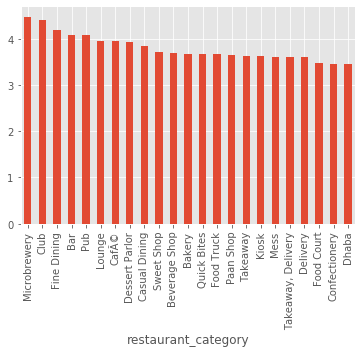

In [1856]:
dfcatratings = df.groupby("restaurant_category")['rating'].mean()
dfcatratings.sort_values(ascending=False).plot.bar()

Microbrewery and Club have the highest average rating while dhaba category has the lowest. 

# 7.In a nutshell,what is liked the most in top 2 restaurant categories.(Club, Microbreweries)

In [1857]:
def combineFeatureText(series,exist=False):
    text = []
    for i in series.iteritems():
        for j in i:
            if type(j) is tuple:
                for k in j[1]:
                    if(exist):
                        if k not in text:
                            text.append(k)
                    else:
                        text.append(k)
                
    return text    

In [1858]:
topCategories = ['Club','Microbrewery']
dfLikedInTopCat = df[df['restaurant_category'].isin(topCategories)]

dfLikedInTopCat = dfLikedInTopCat.dropna(subset=['most_liked_Food'])
dfLikedInTopCat['most_liked_Food'] = dfLikedInTopCat['most_liked_Food'].apply(ast.literal_eval)
mostLikedFoodText = dfLikedInTopCat.groupby(['restaurant_category'])['most_liked_Food'].agg(combineFeatureText,True)

dfLikedInTopCat = dfLikedInTopCat.dropna(subset=['most_liked_Service'])
dfLikedInTopCat['most_liked_Service'] = dfLikedInTopCat['most_liked_Service'].apply(ast.literal_eval)
mostLikedServiceText = dfLikedInTopCat.groupby('restaurant_category')['most_liked_Service'].agg(combineFeatureText,True)

dfLikedInTopCat = dfLikedInTopCat.dropna(subset=['most_liked_Look & Feel'])
dfLikedInTopCat['most_liked_Look & Feel']= dfLikedInTopCat['most_liked_Look & Feel'].apply(ast.literal_eval)
mostLikedLooknFeelText = dfLikedInTopCat.groupby('restaurant_category')['most_liked_Look & Feel'].agg(combineFeatureText,True)

mostLikedCombined = mostLikedFoodText + mostLikedServiceText + mostLikedLooknFeelText



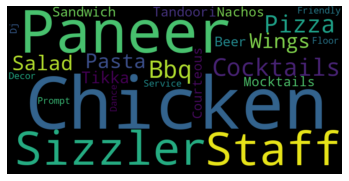

In [1859]:
liked_text = ' '.join(review for review in mostLikedCombined["Club"])

wordcloud = WordCloud(width=800, height=400).generate(liked_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

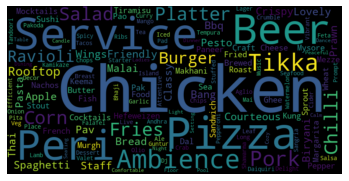

In [1860]:
liked_text = ' '.join(review for review in mostLikedCombined["Microbrewery"])

wordcloud = WordCloud(width=800, height=400).generate(liked_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [1861]:
topCategories = ['Quick bites','Casual Dining',]
dfLikedInTopCat1 = df[df['restaurant_category'].isin(topCategories)]

dfLikedInTopCat = dfLikedInTopCat1[dfLikedInTopCat1['rating'] >= 4.2]

dfLikedInTopCat = dfLikedInTopCat.dropna(subset=['most_liked_Food'])
dfLikedInTopCat['most_liked_Food'] = dfLikedInTopCat['most_liked_Food'].apply(ast.literal_eval)
mostLikedFoodText = dfLikedInTopCat.groupby(['restaurant_category'])['most_liked_Food'].agg(combineFeatureText,False)

cuisines_series = mostLikedFoodText.apply(pd.Series).stack().reset_index(drop=True)
cuisines_series.value_counts(ascending = False)

Mocktails              67
Cocktails              65
Pasta                  63
Pizza                  52
Fish                   52
                       ..
Japanese Cheesecake     1
Kurkure Mushrooms       1
Tofu Dumplings          1
Clear Chicken Soup      1
Lamb Pizza              1
Length: 543, dtype: int64

In [1862]:
topCategories = ['Quick bites','Casual Dining']
dfLikedInTopCat2 = df[df['restaurant_category'].isin(topCategories)]

dfLikedInTopCat = dfLikedInTopCat2[dfLikedInTopCat2['rating'] >= 4.2]

dfLikedInTopCat = dfLikedInTopCat.dropna(subset=['most_liked_Service'])
dfLikedInTopCat['most_liked_Service'] = dfLikedInTopCat['most_liked_Service'].apply(ast.literal_eval)
mostLikedServicedText = dfLikedInTopCat.groupby(['restaurant_category'])['most_liked_Service'].agg(combineFeatureText,False)

service_series = mostLikedServicedText.apply(pd.Series).stack().reset_index(drop=True)
service_series.value_counts(ascending = False)

Friendly Staff       225
Courteous Staff      203
Prompt Service        86
Friendly Service      37
Courteous Service     36
Valet Service         29
Attentive Service      5
Cordial Staff          4
Efficient Service      3
Weekend Brunch         1
dtype: int64

In [1863]:
topCategories = ['Quick bites','Casual Dining',]
dfLikedInTopCat3 = df[df['restaurant_category'].isin(topCategories)]

dfLikedInTopCat = dfLikedInTopCat3[dfLikedInTopCat3['rating'] >= 4.2]

dfLikedInTopCat = dfLikedInTopCat.dropna(subset=['most_liked_Look & Feel'])
dfLikedInTopCat['most_liked_Look & Feel'] = dfLikedInTopCat['most_liked_Look & Feel'].apply(ast.literal_eval)
mostLikedlookFeelText = dfLikedInTopCat.groupby(['restaurant_category'])['most_liked_Look & Feel'].agg(combineFeatureText,False)

service_series = mostLikedlookFeelText.apply(pd.Series).stack().reset_index(drop=True)
service_series.value_counts(ascending = False)

Decor                   202
Lovely Ambience          34
Rooftop Ambience         27
Live Music               26
Comfortable Seating      25
Cozy Place               20
Calm                     16
Cozy Ambience            16
Dj                       13
Live Grill               12
Rooftop Setting          11
Romantic Dinner           9
Cozy                      8
Classy Ambience           6
Peaceful Ambience         6
Classy Place              5
Pool Table                4
Calm Ambience             3
Dance Floor               3
Vibrant Ambience          3
Candle Light Dinner       3
Instrumental Music        2
Chinese Ambience          2
Live Cooking              2
Cute Ambience             2
Wooden Decor              2
Outdoor Ambience          2
Soothing Ambience         2
Dhaba Feel                2
Comfortable Sofas         2
Board Games               2
Village Theme             1
Spectacular View          1
Breakfast Joint           1
Pirate Theme              1
Peppy Music         

# 8.Linear correlation between photos taken and votes

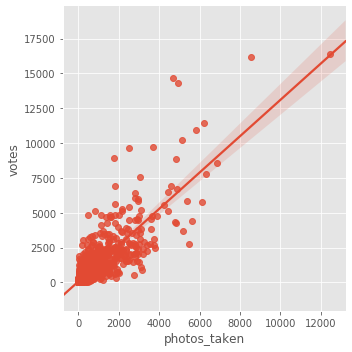

In [1864]:
sns.lmplot('photos_taken','votes',data=df)

# 9.Insight on how Zomato Gold affects ratings of a particular restaurant category in any locality 

In [1865]:
dfZomato = df.groupby(['locality','restaurant_category','zomato_gold'])['rating'].mean()
dfZomato

locality       restaurant_category  zomato_gold
BTM            Bar                  zomato gold    3.600000
               Casual Dining        zomato gold    4.150000
               Dessert Parlor       zomato gold    4.400000
Banashankari   Casual Dining        zomato gold    3.700000
               Lounge               zomato gold    3.900000
                                                     ...   
Whitefield     Pub                  zomato gold    4.200000
Wilson Garden  Casual Dining        zomato gold    3.900000
Yelahanka      Casual Dining        zomato gold    4.033333
Yeshwantpur    Bar                  zomato gold    3.700000
               Casual Dining        zomato gold    3.833333
Name: rating, Length: 155, dtype: float64

In [1866]:
dfNoZomato = df.groupby(['locality','restaurant_category'])['rating'].mean()
dfNoZomato

locality     restaurant_category
BTM          Bakery                 3.660000
             Bar                    3.600000
             Beverage Shop          3.690909
             CafÃ©                  3.769231
             Casual Dining          3.805882
                                      ...   
Yeshwantpur  Pub                    4.100000
             Quick Bites            3.621429
             Sweet Shop             3.450000
             Takeaway                    NaN
             Takeaway, Delivery     3.400000
Name: rating, Length: 820, dtype: float64

locality     restaurant_category
BTM          Bakery                 3.660000
             Bar                    3.600000
             Beverage Shop          3.690909
             CafÃ©                  3.769231
             Casual Dining          3.805882
                                      ...   
Yeshwantpur  Pub                    4.100000
             Quick Bites            3.621429
             Sweet Shop             3.450000
             Takeaway                    NaN
             Takeaway, Delivery     3.400000
Name: rating, Length: 820, dtype: float64

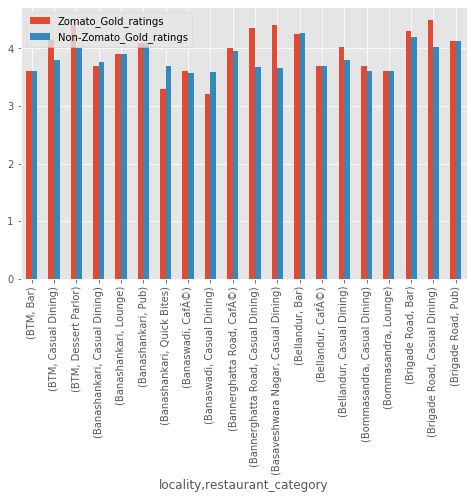

In [1867]:
mergeddf = pd.merge(dfZomato,dfNoZomato,how ='left',on=['locality','restaurant_category'])
slicedMergeddf = mergeddf[0:20] #slice dataframe
ax = slicedMergeddf.plot.bar(figsize=(8,5))
ax.legend(["Zomato_Gold_ratings", "Non-Zomato_Gold_ratings"]);
dfNoZomato

# 10.Insight on Positive & negative sentiments on days of a week

In [1868]:
df['reviews_new'] = df['reviews'].apply(ast.literal_eval)


In [1869]:
review_series = df['reviews_new'].apply(pd.Series).stack().reset_index(drop=True)

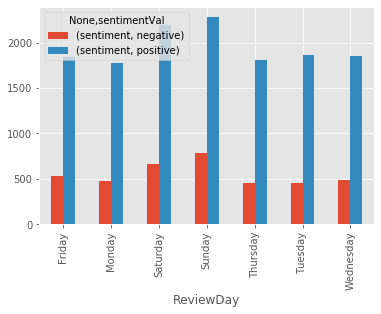

In [1870]:
p = [i[0:3] for i in review_series]

cols = ["ReviewDay","Positive sentiment","Negative sentiment"]
for i,obj in enumerate(p):
    obj[0] = datetime.strptime(obj[0], '%Y-%m-%d %H:%M:%S').strftime('%A')
    
newDF = pd.DataFrame(p,columns=cols)

s = newDF.set_index("ReviewDay").unstack().reset_index()
df3 = s.set_axis(['sentiment', 'ReviewDay','sentimentVal'], axis=1, inplace=False)

df3 = df3[df3.sentimentVal != 'NA']
df4 = df3.groupby(['ReviewDay','sentimentVal']).count()
df4.unstack().plot(kind='bar')


In [827]:
# 10.Insight on Positive & negative sentiments on days of a week

Index(['restaurant_link', 'restaurant_name', 'locality', 'restaurant_category',
       'zomato_gold', 'discounts', 'photos_taken', 'rating', 'votes',
       'cuisines', 'approx_cost_for_2', 'opening_timings', 'address',
       'latitude', 'longitude', 'more_info', 'featured_in', 'known_for',
       'most_liked_Food', 'most_liked_Service', 'most_liked_Look & Feel',
       'reviews', 'reviews_new'],
      dtype='object')

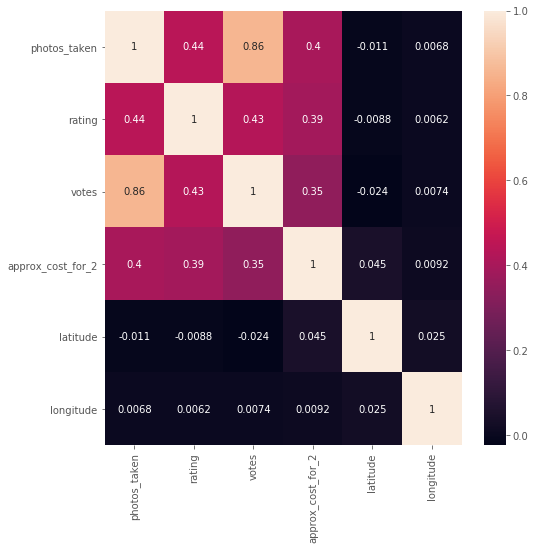

In [1871]:
#getting correlations in different variables 
corr = df.corr(method='pearson')
plt.figure(figsize=(8,8))
ax = sns.heatmap(corr, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
df.columns

# Statistical inferences

In [146]:
#Null hypothesis test to verify the statistical significance of correlation coeficient between photos_taken and votes


We see a strong positive correlation between photos taken and votes.To see how statistically significant corelation is on the population lets take samples and conduct statistical significance test.Lets do a Null hypothesis to test the significance.

H0= Null hypothesis: The correlation coeff = 0 that is, there is no correlation between votes and photos taken.
H1= Alternative hypothesis: The correlation coeff > 0 which means votes and photos taken are positively correlated.


In [1876]:
def pearson_r(x, y):
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0, 1]

In [1877]:
from scipy.stats import pearsonr

photos_arr = df['photos_taken'].replace(np.nan, 0).values
votes_arr = df['votes'].replace(np.nan, 0).values

perm_replicates = np.empty(len(photos_arr))
r_obs = pearson_r(photos_arr,votes_arr)
r_obs

0.860736744875635

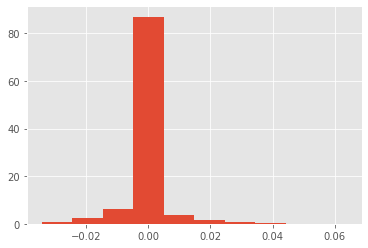

0.0

In [321]:
#Getting sampling distribution of person coeff for a 1000 samples

for i in range(1000):
    photos_arr_permuted = np.random.permutation(photos_arr)
    perm_replicates[i] = pearson_r(photos_arr_permuted, votes_arr)

#plotting the replicates
_ = plt.hist(perm_replicates, bins=10, density=True)
plt.show()

pVal = np.sum(perm_replicates >= r_obs) / len(perm_replicates)
pVal

Since the pvalue is very very small, there is a very small chance to get observed coeffcient value under the assumption of null hypothesis to be true.So,we reject the null hypothesis and accept the alternative hypothesis.  

In [305]:
#Null hypothesis test to verify the statistical significance of zomato gold rating over non zomato gold rating of restaurants

H0= Null hypothesis: The rating of zomato gold is same as a non zomato gold restaurant 
H1= Alternative hypothesis: The rating of zomato gold is greater than a non zomato gold rating.

In [327]:
df.dropna(subset=["rating"],inplace=True)

df['zomato_gold'].fillna('No zomato gold', inplace=True)
grouped = df.groupby('zomato_gold')
groupA = grouped.get_group('zomato gold')
groupB = grouped.get_group('No zomato gold')

obs = np.mean(groupA['rating'])-np.mean(groupB['rating'])
obs

0.3706018814115044

We see a difference of 0.37 in the ratings of a zomato gold and non zomato gold rating which is the observed difference.Let difference in mean be the test statistic. 

# Predictive supervised modelling. 

Getting back to business problem to predict the restaurant rating.We would be modelling a Regression model for the 
prediction.

In [1878]:
#Crearting a new copy of dataframe
dfm = df.copy()

In [1879]:
#Adding some features

In [1880]:
#encoding categorical variables
from sklearn import preprocessing

class Categorical_encoding:
    def __init__(self, df, categorical_features):
        self.df = df
        self.output_df = self.df.copy(deep=True)
        self.cat_features = categorical_features
        
        for c in self.cat_features:
            self.df.loc[:,c] = self.df.loc[:,c].astype(str).fillna(-1)
    
    def label_encoding(self):
        for c in self.cat_features:
            lbl = preprocessing.LabelEncoder()
            lbl.fit(self.df[c].values)
            self.output_df.loc[:,c] = lbl.transform(self.df[c].values)
        
        return self.output_df


In [1881]:
# Label encoding Locality and restaurant category

dfm = dfm.apply(lambda x: x.mask(x.map(x.value_counts()) < 20, 'other') if x.name == 'restaurant_category' else x)
dfm = dfm.apply(lambda x: x.mask(x.map(x.value_counts()) < 20, 'other') if x.name == 'locality' else x)


cols = ['locality','restaurant_category']        
o_df = Categorical_encoding(dfm,cols)  
dfm = o_df.label_encoding()


In [1882]:
dfm["featured_in_count"] = dfm["featured_in"].apply(lambda x: len(ast.literal_eval(x)) if x is not np.nan else x)
dfm["featured_in_count"]

restaurant_ID
18800670    NaN
18771653    NaN
18659224    NaN
18884117    NaN
50915       1.0
           ... 
51496       NaN
18960905    NaN
19224295    NaN
19295651    NaN
55350       NaN
Name: featured_in_count, Length: 5637, dtype: float64

In [1798]:
# nan rating filled with mean rating

# meanrating = dfm['rating'].mean()
# dfm['rating'] = dfm['rating'].fillna(meanrating)
# meanrating

In [1883]:
# converting to numerics

dfm["zomato_gold"] = dfm["zomato_gold"].apply(lambda x: 1 if x == 'zomato gold' else 0)
dfm["discounts"] = dfm["discounts"].apply(lambda x: 1 if x is not np.nan else 0)

In [1884]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

def LabelBinarizerEncoding(categoricalList,colSubset = []):
    mlb = MultiLabelBinarizer()
    res = pd.DataFrame(mlb.fit_transform(categoricalList),columns = mlb.classes_,index = categoricalList.index)
    return res


In [1885]:
# famousCuisines = ['Chinese','North Indian','South Indian','Fast Food']
# famousMostLikedFood = ['Biryani','Pasta','Fish','Mocktails','Salad']
# famousService = ['Friendly Staff','Courteous Staff','Prompt Service']
# famousLookFeel = ['Decor','Rooftop Ambience','Live Music']

famousCuisines = ['Chinese','North Indian','South Indian','Fast Food']
famousMostLikedFood = ['Cocktails','Mocktails','Pizza','Pasta']
famousService = ['Friendly Staff','Courteous Staff']
famousLookFeel = ['Decor']

dfcuisinesbin = LabelBinarizerEncoding(dfm['cuisines'])
dfcuisinesbin_ = dfcuisinesbin[famousCuisines]

dfm["most_liked_Food"] = dfm["most_liked_Food"].apply(lambda x: ast.literal_eval(x)[1] if x is not np.nan else [])
dfostLikedFoodbin = LabelBinarizerEncoding(dfm['most_liked_Food'])
dfostLikedFoodbin_ = dfostLikedFoodbin[famousMostLikedFood]

dfm["most_liked_Service"] = dfm["most_liked_Service"].apply(lambda x: ast.literal_eval(x)[1] if x is not np.nan else [])
dfostLikedServicebin = LabelBinarizerEncoding(dfm['most_liked_Service'])
dfostLikedServicebin_ = dfostLikedServicebin[famousService]

dfm["most_liked_Look & Feel"] = dfm["most_liked_Look & Feel"].apply(lambda x: ast.literal_eval(x)[1] if x is not np.nan else [])
dfostLikedLookFeelbin = LabelBinarizerEncoding(dfm['most_liked_Look & Feel'])
dfostLikedLookFeelbin_ = dfostLikedLookFeelbin[famousLookFeel]


In [1886]:
def addbinarisedCols(binariseddf,colsFilterList):
    for i in range(len(colsFilterList)):
        dfm[colsFilterList[i]] = binariseddf[colsFilterList[i]]

addbinarisedCols(dfcuisinesbin_,famousCuisines)
addbinarisedCols(dfostLikedFoodbin_,famousMostLikedFood)
addbinarisedCols(dfostLikedServicebin_,famousService)
addbinarisedCols(dfostLikedLookFeelbin_,famousLookFeel)

dfm.head(3)

,restaurant_link,restaurant_name,locality,restaurant_category,zomato_gold,discounts,photos_taken,rating,votes,cuisines,...,North Indian,South Indian,Fast Food,Cocktails,Mocktails,Pizza,Pasta,Friendly Staff,Courteous Staff,Decor
restaurant_ID,,,,,,,,,,,,,,,,,,,,,
18800670,https://www.zomato.com/bangalore/machlees-sea-...,Machlee's Sea Food,16,15,0,0,1,3.5,11.0,[Seafood],...,0,0,0,0,0,0,0,0,0,0
18771653,https://www.zomato.com/bangalore/khana-bahaar-...,Khana Bahaar,21,15,0,0,3,NaN,NaN,"[North Indian, Chinese, Biryani]",...,1,0,0,0,0,0,0,0,0,0
18659224,https://www.zomato.com/bangalore/dhabeliwala-j...,Dhabeliwala,24,10,0,0,18,3.8,58.0,"[Street Food, Beverages, Gujarati]",...,0,0,0,0,0,0,0,0,0,0


In [1887]:
# Create training and test sets

# meanVotes = dfm['votes'].mean()
# dfm['votes'] = dfm['votes'].fillna(meanVotes)

dfm['featured_in_count'] = dfm['featured_in_count'].fillna(0)


In [1888]:

dfm = dfm[dfm['rating'].notnull()]

m = dfm['votes'].median()
dfm['votes'] = dfm['votes'].fillna(m)

dfm['photos_taken'] = (dfm['photos_taken']+1).transform(np.log)


/Users/Anand/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/Anand/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Index(['restaurant_link', 'restaurant_name', 'locality', 'restaurant_category',
       'zomato_gold', 'discounts', 'photos_taken', 'rating', 'votes',
       'cuisines', 'approx_cost_for_2', 'opening_timings', 'address',
       'latitude', 'longitude', 'more_info', 'featured_in', 'known_for',
       'most_liked_Food', 'most_liked_Service', 'most_liked_Look & Feel',
       'reviews', 'reviews_new', 'featured_in_count', 'Chinese',
       'North Indian', 'South Indian', 'Fast Food', 'Cocktails', 'Mocktails',
       'Pizza', 'Pasta', 'Friendly Staff', 'Courteous Staff', 'Decor'],
      dtype='object')

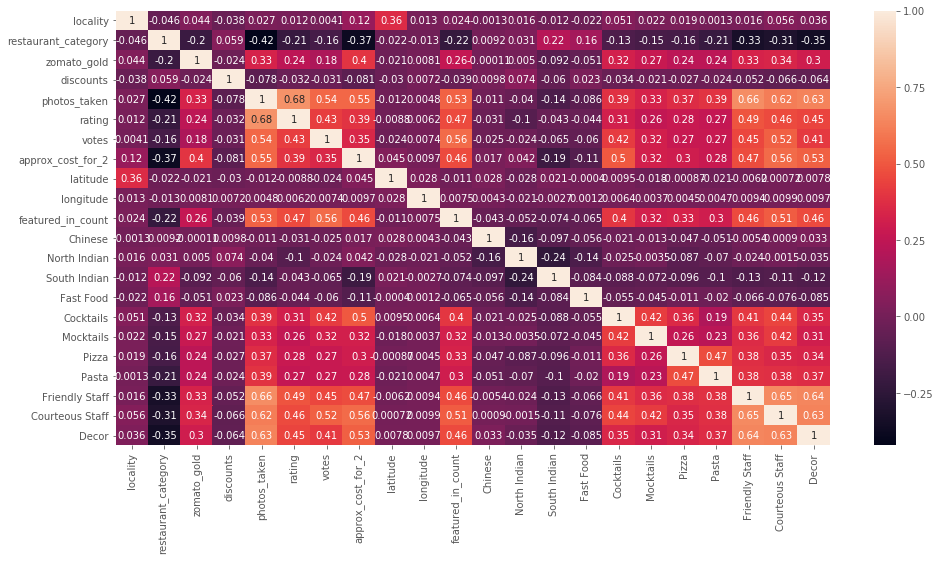

In [1889]:
corr = dfm.corr(method='pearson')
plt.figure(figsize=(16,8))
ax = sns.heatmap(corr, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
dfm.columns

In [1890]:
# Features

# X = dfm[['locality','restaurant_category','photos_taken','votes','approx_cost_for_2','featured_in_count','zomato_gold','discounts',
#         'Chinese','North Indian','South Indian','Fast Food','Biryani','Pasta','Fish','Mocktails','Salad',
#         'Friendly Staff', 'Courteous Staff','Prompt Service','Decor', 'Rooftop Ambience', 'Live Music']]

X = dfm[['locality','restaurant_category','photos_taken','votes','approx_cost_for_2','featured_in_count','zomato_gold','discounts',
        'Fast Food','Cocktails','Mocktails','Pizza','Pasta',
        'Friendly Staff', 'Courteous Staff','Decor']]

y = dfm['rating']



In [1891]:
# LinearRegression

In [1892]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create the regressor: reg_all
reg_all = LinearRegression()

# # Fit the regressor to the training data
reg_all.fit(X_train, y_train)

# # Predict on the test data: y_pred
y_predict = reg_all.predict(X_test)

from sklearn.metrics import r2_score
print(r2_score(y_test,y_predict))

rmse = np.sqrt(mean_squared_error(y_test, y_predict))
print("Root Mean Squared Error: {}".format(rmse))

# errors = abs(y_predict - y_test)
# print(np.mean(errors))

# mape = 100 * (errors / y_test)

# # Calculate and display accuracy
# accuracy = 100 - np.mean(mape)
# print('Accuracy:', round(accuracy, 2), '%.')


0.4943414765888635
Root Mean Squared Error: 0.2683486415639684


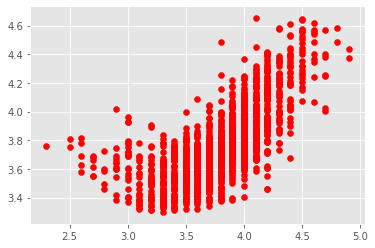

In [1893]:
plt.scatter(y_test, y_predict, color = 'red')

In [ ]:
# RandomForestRegressor

In [1894]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

RForest = RandomForestRegressor(n_estimators=500,random_state=329,min_samples_leaf=50,max_features='auto')

RForest.fit(X_train,y_train)

y_predict = RForest.predict(X_test)

from sklearn.metrics import r2_score
print(r2_score(y_test,y_predict))

rmse = np.sqrt(mean_squared_error(y_test, y_predict))
print("Root Mean Squared Error: {}".format(rmse))


0.5727390218394968
Root Mean Squared Error: 0.24667057733218173


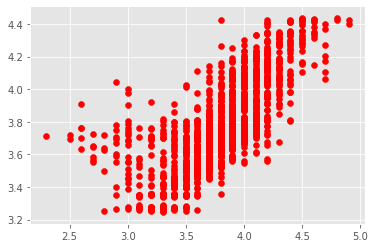

In [1895]:
plt.scatter(y_test, y_predict, color = 'red')

In [753]:
# ExtraTreesRegressor

In [1896]:
from sklearn.ensemble import  ExtraTreesRegressor
ETree=ExtraTreesRegressor(n_estimators = 100)

ETree.fit(X_train,y_train)

y_predict=ETree.predict(X_test)

from sklearn.metrics import r2_score
r2_score(y_test,y_predict)

0.5196798214765714

In [1824]:
# Cross validation test

In [1897]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

reg = LinearRegression()

cv_scores = cross_val_score(reg,X,y,cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))



[0.47311353 0.47868529 0.48620485 0.46968948 0.49999118]
Average 5-Fold CV Score: 0.4815368657002459


In [1812]:


from sklearn.ensemble import RandomForestRegressor


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

RForest = RandomForestRegressor(n_estimators=100,random_state=329,min_samples_leaf=50,max_features='sqrt')

cv_scores = cross_val_score(RForest,X,y,cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))


[0.55559082 0.53857352 0.54771877 0.53653567 0.54903621]
Average 5-Fold CV Score: 0.5454909980980739


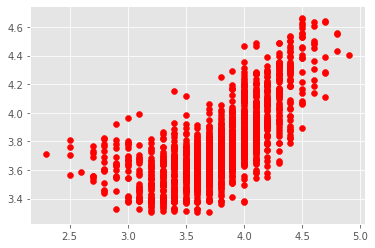